This tutorial deals with __creating a SEG-Y file (rev. 2) from scratch__. 

Let's start by importing some packages (including the seisio package itself) and setting up the logging config.

In [1]:
import logging
import numpy as np

import sys
sys.path.insert(1, '../')

In [2]:
import seisio

In [3]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s', force=True)
log = logging.getLogger("main")

The following defines a Ricker function that simply creates a (possibly shifted) Ricker wavelet. We use that function to simulate our data set later on.

In [4]:
def ricker(t, t0=0.0, fm=30.0):
    """
    Zero-phase Ricker wavelet, possibly shifted in time.

    Parameters
    ----------
    t: 1D numerical array
        Time vector containing times in seconds.
    t0: numerical scalar
        Time shift in seconds. Peak of Ricker wavelet is positioned at t0.
    fm: numerical scalar
        Main frequency in Hertz.

    Returns
    -------
    1D numerical array
        The amplitude values of the Ricker wavelet corresponding to t.
    """
    return (1-2*np.pi**2*fm**2*(t-t0)**2)*np.exp(-np.pi**2*fm**2*(t-t0)**2)

Let's assume we have some high-resolution data with a large number of samples per trace that won't comply with SEGY rev. 0 or 1. We simulate
the data by 10 traces, each trace containing a shifted Ricker wavelet of 5000 Hz):

In [5]:
nt = 10                                # number of traces
ns = 80001                             # number of samples
dt_micro = 0.1                         # sampling interval 0.1 microsec
dt = dt_micro*1e-6                     # sampling interval in sec
t = np.arange(0, (ns-1)*dt+dt/2, dt)   # time vector (for plotting only)
fm = 5000                              # Ricker main frequency in Hertz

data = np.zeros((nt, ns), dtype=np.float32)
for i in np.arange(nt):
    data[i, :] = ricker(t, t0=(i+1)*7000*dt, fm=fm)

In each of the 10 traces, the ricker wavelet is shifted a little bit further in time.

Now we create a SEG-Y output file follwing SEG-Y revision 2 standard, using IEEE floats as data format, and big-endian byte order. We encode the textual file header as 'EBCDIC', and for good measures we throw in two additional textual header records.

In [6]:
file = "data/SEGYrev2.sgy"

out = seisio.output(file, ns=ns, vsi=dt_micro, endian=">", format=5, txtenc="ebcdic", segymaj=2, ntxtrec=2)

INFO: Output file: data/SEGYrev2.sgy
INFO: Output number of samples per data trace: 80001.
INFO: Output data sample format: 4-byte IEEE floating-point.
INFO: Output file endianess set to '>'.
INFO: Number of additional textual header records: 2.
INFO: Byte offset of first trace relative to start of file: 10000 bytes.
INFO: Number of trailer stanza records: 0.
INFO: SEG-Y trace header extension 1 is not present.
INFO: Number of user-defined trace headers: 0
INFO: Creating file according to SEG-Y rev. 2.0.


Now we get a template for a primary SEG-Y textual file header and fill in the first line with some text. We pretty-print the textual header by simply logging it:

In [7]:
txthead = out.txthead_template
txthead[0] = "C01 This is an exemplary textual file header."
out.log_txthead(txthead=txthead, info="Primary textual file header")

INFO: Primary textual file header:
INFO: -------- BEGIN --------
C01 This is an exemplary textual file header.                                   
C02                                                                             
C03                                                                             
C04                                                                             
C05                                                                             
C06                                                                             
C07                                                                             
C08                                                                             
C09                                                                             
C10                                                                             
C11                                                                             
C12                                         

In a similar way, we can get a template for the SEG-Y binary file header, fill in some information, and pretty-print the header by simply logging it:

In [8]:
binhead = out.binhead_template
binhead["job"] = 1
binhead["line"] = 42
binhead["nt"] = nt
out.log_binhead(binhead=binhead)

INFO: SEG-Y binary file header:
+----------+-----------------+----------------------------------------------------------+
|          |           value | description                                              |
|----------+-----------------+----------------------------------------------------------|
| job      |     1           | Job identification number                                |
| line     |    42           | Line number                                              |
| nt       |    10           | Number of traces per ensemble                            |
| format   |     5           | Data sample format code                                  |
| ens      | 80001           | Extended number of samples per data trace                |
| edt      |     0.1         | Extended sample interval (IEEE)                          |
| iconst   |     1.69091e+07 | The integer constant 16909060_10 (01020304_16)           |
| segymaj  |     2           | SEG-Y major format revision number   

As can be seen, the `ns` entry is 0 (therefore not shown) and only the `ens` entry is set - that's because the number of samples is larger than what the `ns` binary header slot could store. The same holds, in principle, for the `dt` entry (only `edt` is present), as a sampling interval of 0.1 microseconds could not be stored in a previous SEG-Y revision.

Let's create two additional SEG-Y header records which follow the binary file header; this is just an example. We could keep it short as seisio will pad the textual header to the required 3200 bytes as required, but we can also get a template and fill in some exemplary data that simulates typical data stored in such additional header records. We again pretty-print the header records by simplye logging them.

In [9]:
txtrec1 = out.txtrec_template
txtrec1[0] = "(( OGP: P1/11 Data Geographic Extent ))"
for i in range(1, len(txtrec1), 1):
    txtrec1[i] = "..."  # fill in some "..." in each line
out.log_txthead(txthead=txtrec1, info="Additional textual header #1")
# the second records is a single string which will automatically be padded
txtrec2 = "(( Company XYZ: User-defined textual header ))"  
out.log_txthead(txthead=txtrec2, info="Additional textual header #2")

INFO: Additional textual header #1:
INFO: -------- BEGIN --------
(( OGP: P1/11 Data Geographic Extent ))                                         
...                                                                             
...                                                                             
...                                                                             
...                                                                             
...                                                                             
...                                                                             
...                                                                             
...                                                                             
...                                                                             
...                                                                             
...                                        

Obviously, we also need some trace headers for our data. So let's get a template for the trace headers and fill in some useful information:

In [10]:
# Create some trace headers for our data
trchead = out.headers_template(nt=nt)
trchead["tracl"] = np.arange(1, nt+1/2, 1)
trchead["cdp"] = np.arange(1, nt+1/2, 1)
trchead["trid"] = 1
trchead["duse"] = 2
dx = 0.01
trchead["scalco"] = -100
trchead["sx"] = trchead["gx"] = 100*np.arange(0, (nt-1)*dx+dx/2, dx)

The header mnemonics `ns` and `dt` cannot be set as the values would overflow but the flag indicating fixed trace lengths is set and the correct values are stored in the SEG-Y binary file header - these values then hold for all traces according to the SEG-Y standard. 

Let's log some statistics for our trace header table we have just created:

In [11]:
thstat = seisio.log_thstat(trchead)

INFO: Summary of trace header statistics (zeros excluded):
+--------+-------+-------+--------+---------+---------+---------+
|        |   min |   max |   mean |     std |     25% |     75% |
|--------+-------+-------+--------+---------+---------+---------|
| tracl  |     1 |    10 |    5.5 | 3.02765 |    3.25 |    7.75 |
| cdp    |     1 |    10 |    5.5 | 3.02765 |    3.25 |    7.75 |
| trid   |     1 |     1 |    1   | 0       |    1    |    1    |
| duse   |     2 |     2 |    2   | 0       |    2    |    2    |
| scalco |  -100 |  -100 | -100   | 0       | -100    | -100    |
| sx     |     0 |     9 |    4.5 | 3.02765 |    2.25 |    6.75 |
| gx     |     0 |     9 |    4.5 | 3.02765 |    2.25 |    6.75 |
+--------+-------+-------+--------+---------+---------+---------+


Now let's write everything we have to disk in our output SEG-Y file:

In [12]:
out.init(textual=txthead, binary=binhead, records=[txtrec1, txtrec2])
out.write_traces(data=data, headers=trchead)
out.finalize()

INFO: SEG-Y textual file header encoding set to 'EBCDIC'.
INFO: SEG-Y ext. textual record 1 encoding set to 'EBCDIC'.
INFO: SEG-Y ext. textual record 2 encoding set to 'EBCDIC'.
INFO: Wrote textual and binary file headers and 2 add. header record(s).
INFO: Swapping bytes of output data.
INFO: Writing 10 trace(s) to disk...
INFO: Finalizing output file and re-writing updated binary header.
INFO: Wrote a total of 10 trace(s), file size: 3212440 bytes.


At this point, we have created a SEG-Y rev. 2 data file with 10 traces.

As a cross-check, let's try to use the __segyio__ package (if installed) to read the file back. We then plot the original data and the data read back by segyio to see whether they match. We also log the trace headers read by segyio:

In [13]:
try:
    import pandas as pd
    import segyio
    from tabulate import tabulate
    import matplotlib.pyplot as plt
except ImportError:
    log.warning("Cannot run consistency check.")
    raise

In [14]:
with segyio.open(file, strict=False) as segyfile:
    log.info("SEGYIO textual file header:\n%s",
             segyio.tools.wrap(segyfile.text[0].decode('ascii'), 80))
    log.info("SEGYIO number of extended headers: %d", segyfile.ext_headers)
    for i in range(segyfile.ext_headers):
        log.info("SEGYIO add. textual file header #%d:\n%s", i+1,
                 segyio.tools.wrap(segyfile.text[i+1].decode('ascii'), 80))
    log.info("SEGYIO binary header:\n%s", segyfile.bin)
    log.info("SEGYIO number of traces: %d", len(segyfile.trace))
    log.info("SEGYIO number of samples: %d", segyfile.samples.size)

    header_keys = segyio.tracefield.keys
    trace_headers = pd.DataFrame(index=range(1, segyfile.tracecount+1), columns=header_keys.keys())
    for k, v in header_keys.items():
        trace_headers[k] = segyfile.attributes(v)[:]

    log.info("%s\n%s", "SEGYIO trace headers:", tabulate(trace_headers.T, headers="keys", tablefmt="psql"))

    segydata = segyfile.trace.raw[:]

INFO: SEGYIO textual file header:
C01 This is an exemplary textual file header.
C02
C03
C04
C05
C06
C07
C08
C09
C10
C11
C12
C13
C14
C15
C16
C17
C18
C19
C20
C21
C22
C23
C24
C25
C26
C27
C28
C29
C30
C31
C32
C33
C34
C35
C36
C37
C38
C39 SEG-Y_REV2.0
C40 END TEXTUAL HEADER
INFO: SEGYIO number of extended headers: 2
INFO: SEGYIO add. textual file header #1:
(( OGP: P1/11 Data Geographic Extent ))
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
INFO: SEGYIO add. textual file header #2:
(( Company XYZ: User-defined textual header ))
INFO: SEGYIO binary header:
{JobID: 1, LineNumber: 42, ReelNumber: 0, Traces: 10, AuxTraces: 0, Interval: 0, IntervalOriginal: 0, Samples: 0, SamplesOriginal: 0, Format: 5, EnsembleFold: 0, SortingCode: 0, VerticalSum: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, Sweep: 0, SweepChannel: 0, SweepTaperStart: 0, SweepTaperEnd: 0, Taper: 0, Cor

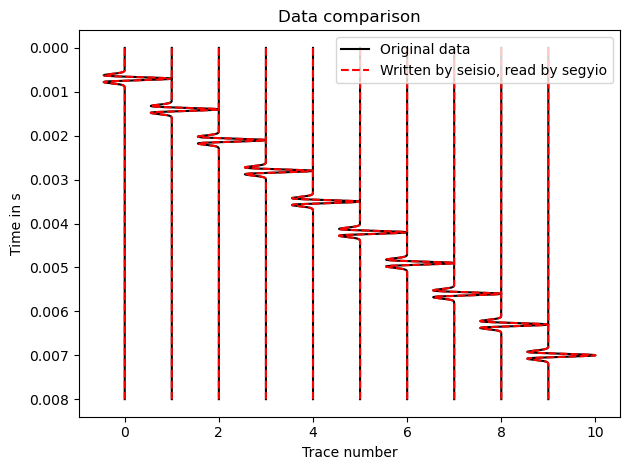

In [15]:
fig, ax = plt.subplots(1, 1)

for i in range(segyfile.tracecount):
    msg = "Original data" if i == 0 else "_ignored"
    ax.plot(i+data[i, :], np.arange(0, (ns-1)*dt+dt/2, dt), 'k-', label=msg)
    msg = "Written by seisio, read by segyio" if i == 0 else "_ignored"
    ax.plot(i+segydata[i, :], np.arange(0, (ns-1)*dt+dt/2, dt), 'r--', label=msg)

ax.invert_yaxis()
ax.legend()
ax.set_title("Data comparison")
ax.set_xlabel("Trace number")
ax.set_ylabel("Time in s")

plt.tight_layout()
plt.show()

Note: We provide another Python package called __seisplot__ for displaying seismic data in a convenient way.